In [1]:
from sbdataextraction import sbdataextraction as sbd
from graphdistance import largest_distance, get_sequences

import time 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_edges
from networkx.algorithms.dag import dag_longest_path

# Analyzing pass sequences using clustering and expected goals

## 1. Getting the data

In [2]:
season_11_21 = sbd.fetch_matches_for_season(11, 21)

Fetching matches for season_id 21 of competition_id 11...
[==================================] 100%

In [3]:
game_event_graphs = {}
season_event_df = season_11_21[69239].get_events_for_game()
for game_id, game in season_11_21.items():
    event_df = game.get_events_for_game()
    if game_id != 69239:
        season_event_df = season_event_df.append(event_df)
    events_graph = nx.Graph()
    events_graph.add_nodes_from(game.event_df.index)
    for index, row in event_df.iterrows():
        if row["related events"] is not None:
            events_graph.add_edges_from([(index, x) for x in row["related events"] if x in event_df.index])
        
    game_event_graphs[game_id] = events_graph

In [4]:
all_sequences_for_season = []
for game_id, game_graph in game_event_graphs.items():
    all_sequences_for_game = get_sequences(game_event_graphs[game_id])
    all_sequences_for_season.append(all_sequences_for_game)

## 2. Pass clustering

In [5]:
import math
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [6]:
season_pass_df = season_event_df[season_event_df["event name"] == "pass"].iloc[:, 5:9]
x1 = season_pass_df["x start location"]
x2 = season_pass_df["x end location"]
y1 = season_pass_df["y start location"]
y2 = season_pass_df["y end location"]
season_pass_df["length"] = np.sqrt((x2-x1)**2 + (y2-y1)**2)
season_pass_df["angle"] = list(map(lambda x, y: math.atan2(x, y), x2-x1, y2-y1))
season_pass_df

,x start location,y start location,x end location,y end location,length,angle
event id,,,,,,
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247,61.0,41.0,62.1,40.1,1.421267,2.256526
a5625b97-1c9d-4262-9179-0ac2ba69867f,62.8,46.1,69.9,68.0,23.022163,0.313509
af327f67-0dd3-4464-a505-e0c7bde4d29d,71.6,75.1,92.5,79.9,21.444113,1.345046
09e078a9-cfa2-4a03-8d4d-a33529d95819,105.5,80.0,80.2,69.4,27.430822,-1.967550
5b7a45a1-3cc3-4cf1-ad60-69bef51ec545,76.5,60.2,54.0,40.9,29.643549,-2.279788
...,...,...,...,...,...,...
6a0f145b-d417-484c-ae38-37054e4703ef,62.9,76.2,80.8,65.5,20.854256,2.109571
9075d00f-ad29-4dad-b010-1a9c12742a1a,80.8,65.5,115.2,47.9,38.640911,2.043703
83b1e530-2286-492c-971d-3759c6ec85d5,9.4,48.9,80.0,57.5,71.121867,1.449580


In [7]:
cols = ["x start location", "y start location", "length", "angle"]
ss = StandardScaler()
season_pass_df_transformed = ss.fit_transform(season_pass_df[cols])
season_pass_df_transformed

array([[ 0.07680454,  0.02384468, -1.37677736,  1.00425552],
       [ 0.14629899,  0.24426414,  0.1189719 , -0.08715424],
       [ 0.48604963,  1.49762972,  0.00970019,  0.49226927],
       ...,
       [-1.91536967,  0.36527875,  3.44962522,  0.55098718],
       [-0.56408871, -0.70656492,  3.20465302,  0.38913384],
       [-1.74549435, -0.61580396,  5.41195851,  0.45406308]])

In [8]:
n_cluster = 81
kmeans = KMeans(n_clusters=n_cluster, n_init=10)
kmeans.fit_predict(season_pass_df_transformed);

In [9]:
season_pass_df["cluster"] = kmeans.labels_

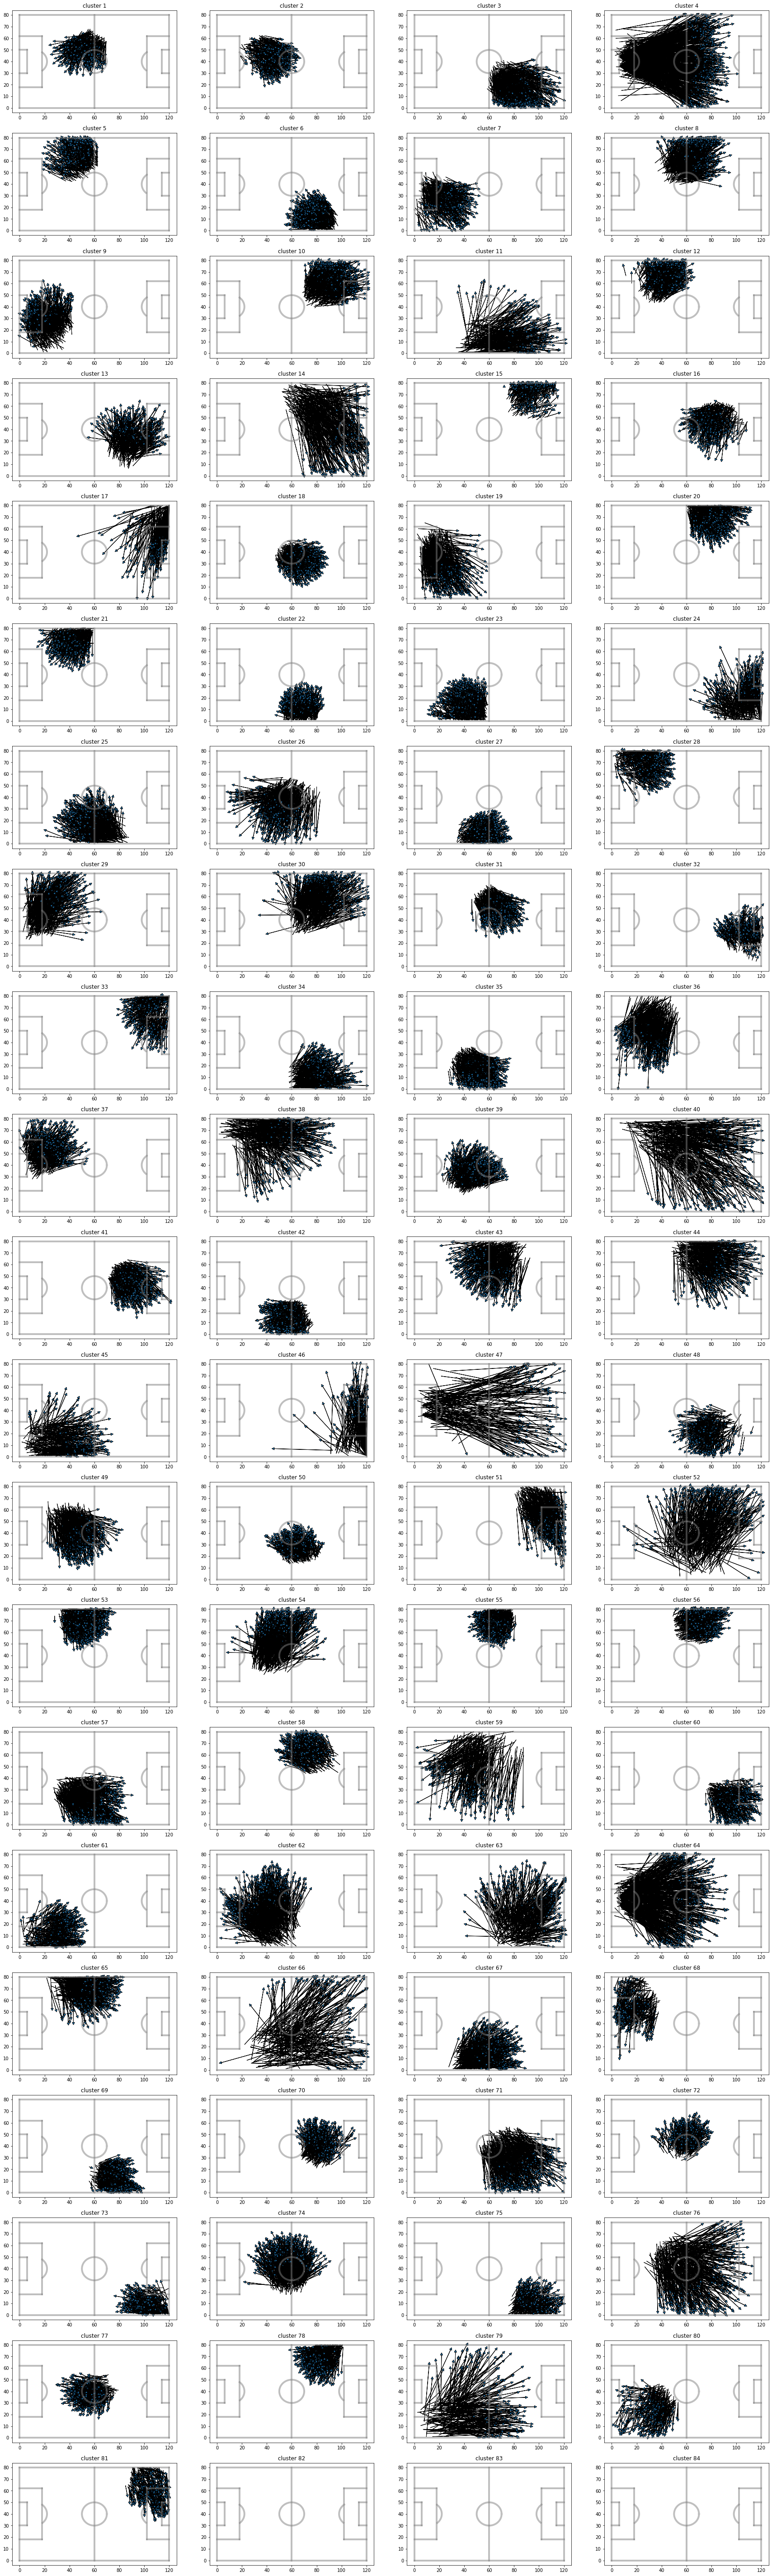

In [10]:
axis_cols = 4
axis_rows = int(np.ceil(n_cluster / axis_cols))
fig, axs = plt.subplots(axis_rows, axis_cols, figsize=(30, 0.66*(30/axis_cols)*axis_rows))
ax = axs.reshape(-1)
for i, axi in enumerate(ax):
    sbd.draw_pitch(axis=axi, rotate=True)
    axi.set_title(f"cluster {i+1}", size=12)
for game_id, game in season_11_21.items():
    event_df_game = game.event_df
    pass_df_game = event_df_game[event_df_game["event name"] == "pass"]
    for index, row, in pass_df_game.iterrows():
        axis_num = int(season_pass_df.loc[index]["cluster"])
        sbd.plot_event(game, index, axis=ax[axis_num])

## 3. Rating passes with xg

In [15]:
all_sequences_xg = []
for game_sequences in all_sequences_for_season:
    for sequence in game_sequences:
        xg = 0
        for event_id in sequence:
            if season_event_df.loc[event_id]["event name"] == "shot":
                xg = season_event_df.loc[event_id]["statsbomb xg"]
        all_sequences_xg.append(xg)

In [56]:
n=0
for xg in all_sequences_xg:
    if xg != 0:
        n+=1
n

396

In [16]:
event_xg_dict = {}
for game_sequences in all_sequences_for_season:
    for i, sequence in enumerate(game_sequences):
        for event_id in sequence:
            event_xg_dict[event_id] = all_sequences_xg[i]

In [70]:
event_xg_column = []
for index, row in season_pass_df.iterrows():
    xg = 0
    if index in event_xg_dict.keys():
        xg = event_xg_dict[index]
    event_xg_column.append(xg)

In [72]:
season_pass_df["event xg"] = event_xg_column

In [79]:
season_pass_df.groupby("cluster").mean().sort_values("event xg", ascending=False)

,x start location,y start location,x end location,y end location,length,angle,event xg
cluster,,,,,,,
36,15.606193,46.117661,26.899771,57.527752,18.050938,0.784392,0.007439
32,110.036207,69.687438,102.178079,61.936453,13.116291,-2.320123,0.007425
6,17.644060,32.001944,28.830454,22.685097,16.302238,2.255494,0.006909
33,70.115854,8.535122,86.870244,15.629756,20.116951,1.166369,0.006212
13,73.344178,63.328767,103.061644,27.294863,51.280479,2.428835,0.006158
...,...,...,...,...,...,...,...
25,56.441043,42.581859,45.754875,24.183220,24.256867,-2.596864,0.001053
46,14.138129,44.282734,95.882014,38.561151,86.669851,1.645829,0.000915
49,66.281701,23.102033,63.643068,32.502403,11.210486,-0.289293,0.000671
